# MLiM 25440 Homework 2 : Programming Assignment
### Brendan Sanderson

#### Imports and Mounting

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, utils

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Helper functions

In [0]:
# Timer helper class for benchmarking reading methods
class Timer(object):
    """Timer class
       Wrap a will with a timing function
    """
    
    def __init__(self, elapsed):
        self.elapsed = elapsed
        
    def __enter__(self):
        self.t = time.time()
        
    def __exit__(self, *args, **kwargs):
        tim =  time.time() - self.t
        self.elapsed.append(tim)
        
        

This function will run the 5-fold cross validation with a given model, X and Y. It will return the confusions matrix, the f1 score, the percent error and the total runtime to fit the model.

In [0]:
#Run cross validation with 5-folds and returns the confusion matrix

def five_fold_predict_stats(model, X, Y, c=2):
  cm = np.zeros((c,c), dtype=int)
  f1s = []
  accs = []
  tim = []
  unique_labels = np.unique(Y)
  kf = KFold(n_splits=5)
  #Run 5 times with each fold
  for train_index, test_index in kf.split(X):
      X_train, X_test = X.values[train_index], X.values[test_index]
      y_train, y_test = Y[train_index], Y[test_index]
      with Timer(tim):
        model.fit(X_train, y_train)
      y_hat = model.predict(X_test)
      cm +=confusion_matrix(y_test, y_hat, labels=unique_labels)
      f1s.append(f1_score(y_test, y_hat, average='micro'))
      accs.append(np.mean(y_hat != y_test))
  
  #Return the aggregate of the scores for all folds
  return (cm, np.mean(f1s), np.mean(accs),np.mean(tim))

#Print statement for printing the results from the five fold confusion matrix function

def print_five_fold_results(dataset_name, model_name, results):
  print("")
  print("----------------------------------------------------")
  print("Results for running", model_name, "with the", dataset_name,"Dataset")
  print("The confusion matrix is:")
  print(results[0])
  print("The f1 score is:", results[1])
  print("The percent error is:", results[2])
  print("The average runtime for training is:", results[3], "seconds")
  print("----------------------------------------------------")
  print("")
  
  

## Part 1. Normal and Tumor Match Pair Analysis (30 points)

#### Loading and Preprocessing the data

In [0]:
nt_coding = pd.read_csv(
    "/content/drive/My Drive/MLiM-Datasets/HW2/nt.coding.csv",
    dtype=float,
    keep_default_na=False,
    na_values=[])

nt_all = pd.read_csv(
    "/content/drive/My Drive/MLiM-Datasets/HW2/nt.all.csv",
    dtype=float,
    keep_default_na=False,
    na_values=[])


In [0]:
#Savings the labels as a seperate data frame and removes them from the original dataframe.

nt_labels = nt_coding.pop("Type").values
_ = nt_all.pop("Type").values


In [0]:
# Normalize the data

def normalize_large_data(df):
  scaler = preprocessing.StandardScaler()
  columns = df.columns
  scaled_df = scaler.fit_transform(df)
  return pd.DataFrame(scaled_df, columns=columns)

nt_coding = normalize_large_data(nt_coding)
nt_all = normalize_large_data(nt_all)

### a) Using SciKit Learn build a machine learning classifier that takes RNAseq profiles from matched normal tumor pairs and classifies the sample as Normal or Tumor. Compare the nt.coding.csv vs the nt.all.csv.

I am chosing to use a Linear SVM model for this part. I chose this model because it gives very accurate results in a shorter runtime. It is a fairly standard model, which will provide a good measure of which dataset is better.

In [0]:
#Run the predict function on both data sets and print
cr = five_fold_predict_stats(LinearSVC(tol=1e-5, random_state=0),nt_coding, nt_labels)
ar = five_fold_predict_stats(LinearSVC(tol=1e-5, random_state=0),nt_all, nt_labels)

print_five_fold_results("Protein Coding Genes", "Linear SVM", cr)
print_five_fold_results("All Genes", "Linear SVM", ar)


----------------------------------------------------
Results for running Linear SVM with the Protein Coding Genes Dataset
The confusion matrix is:
[[680  20]
 [ 20 680]]
The f1 score is: 0.9714285714285715
The percent error is: 0.02857142857142857
The average runtime for training is: 4.023158025741577 seconds
----------------------------------------------------


----------------------------------------------------
Results for running Linear SVM with the All Genes Dataset
The confusion matrix is:
[[682  18]
 [ 26 674]]
The f1 score is: 0.9685714285714286
The percent error is: 0.03142857142857143
The average runtime for training is: 6.419310569763184 seconds
----------------------------------------------------



The protein coding gene dataset did slightly better than the all gene dataset in terms of testing error by a slight margin. This seems to allude that the protein coding genes are definitely the more relevant ones and thus in the dataset with all genes, there is a lot of data that is just noise. This could lead the model to slightly overfit to the data and fit to genes that just coincidentally appear to be correlated with the classification. In addition, the coding data run faster. The only thing that the all data set performed better on was the false positives. 

It is important to note that this difference is extremely small. However, as the coding dataset did perform better, I will use only that one going forward.

### b) Using model selection methods of your choice determine which classical ML method performs best on the NT classification problem.


Becaues the coding dataset performed better and has much faster run times, I am going to continue with only using that dataset.

In [0]:
#Names of different classifiers that we will use
names = ["Linear SVM", "Auto SVM", "Nearest Neighbors", 
         "Decision Tree", "Random Forest", "AdaBoost"]

#Instantiating list of classifiers
classifiers = [
    LinearSVC(random_state=0, tol=1e-5),
    SVC(random_state=0, gamma='auto'),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0, n_estimators = 25),
    AdaBoostClassifier(random_state=0)
]

#Run the 5-fold fit and prediction test on each classifier.
classifier_results = []
for name, clf in zip(names, classifiers):
  results = five_fold_predict_stats(clf, nt_coding, nt_labels)
  print_five_fold_results("Protein Coding Genes", name, results)
  classifier_results.append(results)


----------------------------------------------------
Results for running Linear SVM with the Protein Coding Genes Dataset
The confusion matrix is:
[[680  20]
 [ 20 680]]
The f1 score is: 0.9714285714285715
The percent error is: 0.02857142857142857
The average runtime for training is: 4.1091948509216305 seconds
----------------------------------------------------


----------------------------------------------------
Results for running Auto SVM with the Protein Coding Genes Dataset
The confusion matrix is:
[[673  27]
 [ 16 684]]
The f1 score is: 0.9692857142857143
The percent error is: 0.03071428571428571
The average runtime for training is: 15.001606607437134 seconds
----------------------------------------------------


----------------------------------------------------
Results for running Nearest Neighbors with the Protein Coding Genes Dataset
The confusion matrix is:
[[687  13]
 [125 575]]
The f1 score is: 0.9014285714285715
The percent error is: 0.09857142857142856
The average 

All of the models performed fairly well and non had an error more than 0.1. The Linear SVM tied for the best error with the AdaBoost. However, the Linear SVM performed much faster. Thus, I would conclude that the Linear SVM is generally the best model.

Although the Linear SVM is generally the best model, there are still specific cases where other models may be better. 

The RandomForest performed only slightly worse, but has a significantly faster runtime. This means that if your dataset is extremely large, it may be better to use the RandomForest instead of LinearSVM. 

The BestKNeighbors may be the best if you really don't want false positives. It had the least amount of false positives, but a low accuracy. However, if the tradeoff is worth it to you, then this could be a good option.

### c) Using feature selection methods of your choice determine a < 100 gene signature that can be used to classify Normal vs Tumor.

First, we are going to use SelectKBest to reduce the features down to 10,000. After, this I will run ExtraTreesClassifier and remove the bottom 20% of useful features iterateively. Everytime I remove features, I will calculate the error and the runtime of training and testing the model with Linear SVM.

In [0]:
#A wrapper function for get k best
def get_K_best(df, labels, k):
  mini = np.min(np.min(df))
  selectKBest = SelectKBest(chi2, k=k)
  select_df = selectKBest.fit_transform(df-mini, labels)+mini
  column_inds = selectKBest.get_support(indices = True)
  new_columns = [df.columns[i] for i in column_inds]
  return pd.DataFrame(df, columns = new_columns)

#Get the 10,000 best features
nt_10k_coding = get_K_best(nt_coding, nt_labels, 10000)

In [0]:
nt_select_coding = nt_10k_coding.copy()
nt_select_labels = nt_labels

model = ExtraTreesClassifier(n_estimators = 50)
errors = []
times = []

#First, get the error with all features
r = five_fold_predict_stats(LinearSVC(tol=1e-5, random_state=0),nt_coding, nt_labels)
features = [len(nt_coding.columns)]
errors.append(r[2])
times.append(r[3])

#Next, get the error with 10000 features
r = five_fold_predict_stats(LinearSVC(tol=1e-5, random_state=0),nt_select_coding, nt_labels)
errors.append(r[2])
times.append(r[3])
features.append(10000)

#Set the number of max iterations
mi = 1000

#Run 20 interations of removing the bottom 20% features.
for i in range(20):
  model.fit(nt_select_coding, nt_select_labels)
  feature_rankings = model.feature_importances_
  sorted_test = sorted(list(enumerate(feature_rankings)),key= lambda x: x[1])
  nt_select_coding = nt_select_coding.drop(columns=[nt_select_coding.columns[x[0]] for x in sorted_test[:int(len(sorted_test)*0.2)]])
  
  #With less features, the model can take longer to converge, so we will increase the max iterations
  if (len(nt_select_coding.columns) < 3000):
    mi = 2500
  if (len(nt_select_coding.columns) < 1000):
    mi = 5000
    
  #Run the 5-fold predict test
  r = five_fold_predict_stats(LinearSVC(max_iter= mi, tol=1e-5, random_state=0),nt_select_coding, nt_labels)
  errors.append(r[2])
  times.append(r[3])
  features.append(len(nt_select_coding.columns))

   

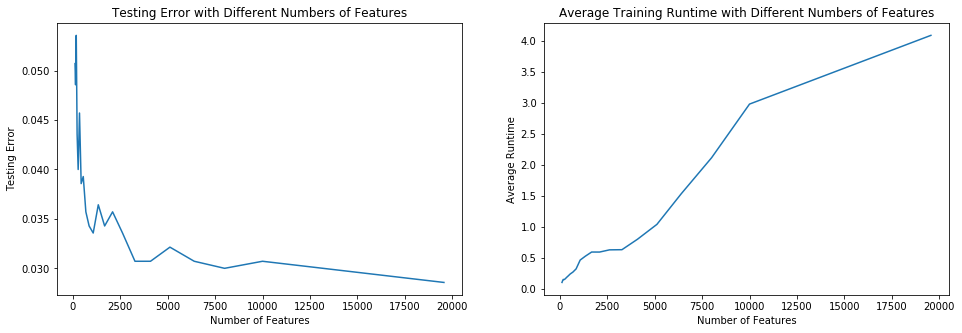

In [0]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(features,errors)
plt.title("Testing Error with Different Numbers of Features")
plt.xlabel("Number of Features")
plt.ylabel("Testing Error")
plt.subplot(1,2,2)
plt.plot(features,times)
plt.title("Average Training Runtime with Different Numbers of Features")
plt.xlabel("Number of Features")
plt.ylabel("Average Runtime")
plt.show()

The testing error generally trended towards going up. This is not surprising as less features seem to indicate less data. Interestingly though, that at only around 2,750 features, the testing error still had not increased dramatically. It increased by less than 0.5%. The significant thing here is the dramatic decrease in runtime. At 2,750, the runtime is 1/8 what it was for all of the features. This shows that feature reduction is definitely a valid method if the dataset is too large and the runtime is too long. 

### d) Using Keras, build a deep learning classifier that performs the same classification task, and determine the learning curve (relationship of number of training samples to prediction accuracy) for your network, recommend using at least 10 training set sizes to estimate the learning curve.

For this section, I tried it first with two different models: A CNN similar to that in class and a fully connected NN similar to the other one in class. I found that they both performed well, but the fully connected one was way faster, so I decided to use that one. I have left the functions for both networks before. Also, I used only 10 epochs as I found that this was enough for the error to converge.

In [0]:
#A cnn model for classification
def classification_model_cnn(i,c):
  model = models.Sequential()
  model.add(layers.Conv1D(filters=16, kernel_size=4, strides=1, padding='valid', input_shape=(i,1)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling1D(pool_size=1))
  model.add(layers.Conv1D(filters=16, kernel_size=1, strides=1, padding='valid'))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling1D(pool_size=10))
  model.add(layers.Flatten())
  model.add(layers.Dense(200))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(20))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(c))
  model.add(layers.Activation('softmax'))
  model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(), metrics=['accuracy'])
  return model


#A fully connected model for classification
def classification_model_fc(i,c):
  model = models.Sequential()
  model.add(layers.InputLayer(i,))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(c, activation='softmax'))
  model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=['accuracy'])
  return model

In [0]:
#Runs 5 fold on the model and returns the error on a seperate testing set
def five_fold_nn_samples(model, X, y, eps, samples = 1000):
  train_errors = []
  valid_errors = []
  test_errors = []
  ns = 5
  if samples < 10:
    ns = 2
  kf = KFold(n_splits=ns)
  X_test = X[-400:]
  Y_test = y[-400:]
  model.save_weights('empty')
  for train_index, test_index in kf.split(X[:samples]):
      X_train, X_val = X.values[train_index], X.values[test_index]
      y_train, y_val = utils.to_categorical(y)[train_index], utils.to_categorical(y)[test_index]
      hist = model.fit(x=X_train, y=y_train, epochs=eps, batch_size=25, shuffle=True, validation_data=(np.array(X_val), y_val))
      train_errors.append(hist.history.get('acc')[-1])
      valid_errors.append(hist.history.get('val_acc')[-1])
      test_errors.append(np.mean([x[1] for x in np.rint(model.predict(X_test))] != Y_test))
      model.load_weights('empty')
  return np.mean(test_errors)

In [0]:
set_sizes = [3,7,15,30,60,125,250,500,1000]
testing_errors = []
for s in set_sizes:
  testing_errors.append(five_fold_nn_samples(classification_model_fc(len(nt_coding.columns),2), nt_coding, nt_labels, 10, samples=s))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 1 samples, validate on 2 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 0.6154 - acc: 1.0000 - val_loss: 2.5266 - val_acc: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 26ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.5266 - val_acc: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 17ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.5266 - val_acc: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 17ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.5266 - val_acc: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 17ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.5266 - val_acc: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 18ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 2.5266 - val_acc: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 18ms/sample - loss: 

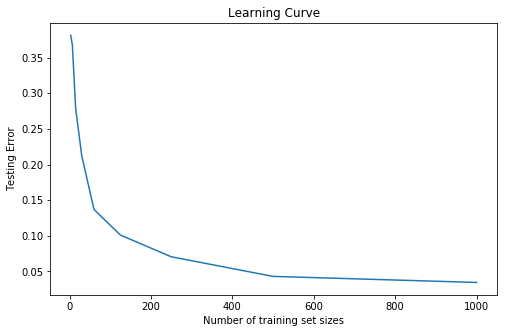

In [0]:
plt.figure(figsize=(8, 5))
plt.plot(set_sizes,testing_errors)
plt.title("Learning Curve")
plt.xlabel("Number of training set sizes")
plt.ylabel("Testing Error")
plt.show()

The learning curve is clearly a parabola. As one would expect, the error increases as you use less data. Also, the higher the percent change in data, the bigger that lose is. This outcome makes sense as the difference between 900 and 1000 datasets should be much less than the different between 200 and 100 datasets.

What is interseting is that the error doesnt really start to dramatically fall off until about 250 datasets. Overall, I would still use as many datasets as possible in order to make sure the results as the best.

## Part 2. Cancer Type Classifier for 18 Common Tumor Types (40 points)

As part 2 does a similar thing to part 1, I reused a lot of the functions, so if you cannot find a definition look above.

#### Loading and Proprocessing Data


In [0]:
#Used for quickly loading only all of the coding data.
type_coding = pd.read_csv(
    "/content/drive/My Drive/MLiM-Datasets/HW2/type.coding.csv")
type_labels = type_coding.pop("Type").values

def normalize_large_data(df):
  scaler = preprocessing.StandardScaler()
  columns = df.columns
  scaled_df = scaler.fit_transform(df)
  return pd.DataFrame(scaled_df, columns=columns)

type_coding = normalize_large_data(type_coding)


In [0]:
type_coding = pd.read_csv(
    "/content/drive/My Drive/MLiM-Datasets/HW2/type.coding.csv")
print("Loaded Coding")
type_all = pd.read_csv(
    "/content/drive/My Drive/MLiM-Datasets/HW2/type.all.csv")

Loaded Coding


In [0]:
#Savings the labels as a seperate data frame and removes them from the original dataframe.
type_labels = type_coding.pop("Type").values
_ = type_all.pop("Type").values

In [0]:
# Normalize the data
def normalize_large_data(df):
  scaler = preprocessing.StandardScaler()
  columns = df.columns
  scaled_df = scaler.fit_transform(df)
  return pd.DataFrame(scaled_df, columns=columns)

type_coding = normalize_large_data(type_coding)
type_all = normalize_large_data(type_all)


### a. Using SciKit Learn build a machine learning classifier that classifies Cancer Type from the type.coding.csv and type.all.csv files. Compare the coding vs all genes cases.


Linear SVC was taking forever to run (I stopped after 30 min), so I decided to use RandomForest for this part.

In [0]:
#Run random forest 5 times on 
cr = five_fold_predict_stats(RandomForestClassifier(random_state=0, n_estimators = 25),type_coding, type_labels, c=18)
ar = five_fold_predict_stats(RandomForestClassifier(random_state=0, n_estimators = 25),type_all, type_labels, c=18)

In [0]:
print_five_fold_results("Protein Coding Genes", "Random Forest", cr)
print_five_fold_results("All Genes", "Random Forest", ar)


----------------------------------------------------
Results for running Random Forest with the Protein Coding Genes Dataset
The confusion matrix is:
[[300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 276   0   0   0   0  10   0   0   1   5   0   0   0   0   0   8   0]
 [  0   0 283  15   0   0   0   0   0   2   0   0   0   0   0   0   0   0]
 [  0   0  11 285   0   0   0   0   0   0   4   0   0   0   0   0   0   0]
 [  0   0   0   1 296   0   0   0   0   3   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 279  16   0   0   0   1   1   0   0   0   2   1   0]
 [  0  10   0   0   1  37 244   0   0   1   5   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0 299   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   1   0   0 298   0   0   0   1   0   0   0   0   0]
 [  0   1   0   0   0   0   0   0   0 299   0   0   0   0   0   0   0   0]
 [  0  13   0   0   0   1  10   0   0   5 260   1   0   0   0   1   8   1]
 [  0   3   0   0   1   

Similar to Part 1, the coding data performed slightly better. The error rate was slightly lower and the runtime was faster. For this reason, I will proceed with the coding data set again.

### b. Using model selection methods of your choice, determine which classical ML method performs best.

I removed the SVC classifiers as they took too long to run. I used the rest.

In [0]:
names = [
         "AdaBoost",
         "Nearest Neighbors", 
         "Decision Tree", 
         "Random Forest"
]

classifiers = [
   # LinearSVC(random_state=0, tol=1e-5),
   # SVC(random_state=0, gamma='auto'),
    AdaBoostClassifier(random_state=0),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0, n_estimators = 25)
]

classifier_results = []
for name, clf in zip(names, classifiers):
  results = five_fold_predict_stats(clf, type_coding, type_labels, c=18)
  print_five_fold_results("Protein Coding Genes", name, results)
  classifier_results.append(results)


----------------------------------------------------
Results for running AdaBoost with the Protein Coding Genes Dataset
The confusion matrix is:
[[128   0   0   0   0   0   0   0   0   0   0 103   0   0   0   0  69   0]
 [  0  60   0  60   0   0  58  57   0   0   0   0   0   0   0   0  65   0]
 [  1  59   0  56   0   0  62  55   0   0   0   0   0   0   0   0  67   0]
 [  0  60   0  45   0   0  67  68   0   0   0   0   0   0   0   0  60   0]
 [  0  60   0   2  50   0  63  55   0   0   0   0   0   0   0   0  70   0]
 [  0  60   0  55   0   0  70  55   0   0   0   0   0   0   0   0  60   0]
 [  0  60   0  60   0   2  56  63   0   0   0   0   0   0   0   0  59   0]
 [  0  60   0  61   0   0  65  50   0   0   0   0   1   0   0   0  63   0]
 [  0  58   0   0   0   0  59  56  64   0   0   0   2   0   0   0  61   0]
 [  0  60   0  57   0   0  56  74   0   0   0   0   0   0   0   0  53   0]
 [  0  60   0  58   0   0  59  62   0   0   0   0   0   0   0   0  61   0]
 [  1  60   0  55   0   0  64

The random forest and nearest neighbors had the lowest error rates (RandomForest had a slightly better error rate). KNeighbors suprisingly had the lowest runtime. I will use RandomForest going forward as the confusion matrix makes it look more reliable. KNeighbors actually took a while to predict the data, which was interesting as I normally expect the training to be the hard part. I was surprised by how poorly AdaBoost performed given how well it did in part 1.

### c. Using feature selection methods of your choice, determine a < 100 gene signature that can be used to classify tumor type.

I do the same thing as before where I first reduce the dimensions to 10,000 through selectKBest and then iteratively use ExtraTreesClassifier to determine the worst features and reduce dimension. I use RandomForest to classify the model here as SVCLinear took too long to run.

In [0]:
def get_K_best(df, labels, k):
  mini = np.min(np.min(df))
  selectKBest = SelectKBest(chi2, k=k)
  select_df = selectKBest.fit_transform(df-mini, labels)+mini
  column_inds = selectKBest.get_support(indices = True)
  new_columns = [df.columns[i] for i in column_inds]
  return pd.DataFrame(select_df, columns = new_columns)

type_10k_coding = get_K_best(type_coding, type_labels, 10000)

In [0]:
type_select_coding = type_10k_coding.copy()
type_select_labels = type_labels

model = ExtraTreesClassifier(n_estimators = 50)
errors = []
times = []

#Add once for original model
r = five_fold_predict_stats(RandomForestClassifier(n_estimators = 25),type_coding, type_labels, c = 18)
features = [len(type_coding.columns)]
errors.append(r[2])
times.append(r[3])

#Add once for 10k model
r = five_fold_predict_stats(RandomForestClassifier(n_estimators = 25),type_select_coding, type_labels, c = 18)
errors.append(r[2])
times.append(r[3])
features.append(10000)
mi = 1000
for i in range(20):
  model.fit(type_select_coding, type_select_labels)
  feature_rankings = model.feature_importances_
  sorted_test = sorted(list(enumerate(feature_rankings)),key= lambda x: x[1])
  type_select_coding = type_select_coding.drop(columns=[type_select_coding.columns[x[0]] for x in sorted_test[:int(len(sorted_test)*0.2)]])
  if (len(type_select_coding.columns) < 3000):
    mi = 2500
  if (len(type_select_coding.columns) < 1000):
    mi = 5000
  r = five_fold_predict_stats(RandomForestClassifier(random_state=0, n_estimators = 25),type_select_coding, type_labels, c = 18)
  errors.append(r[2])
  times.append(r[3])
  features.append(len(type_select_coding.columns))

   

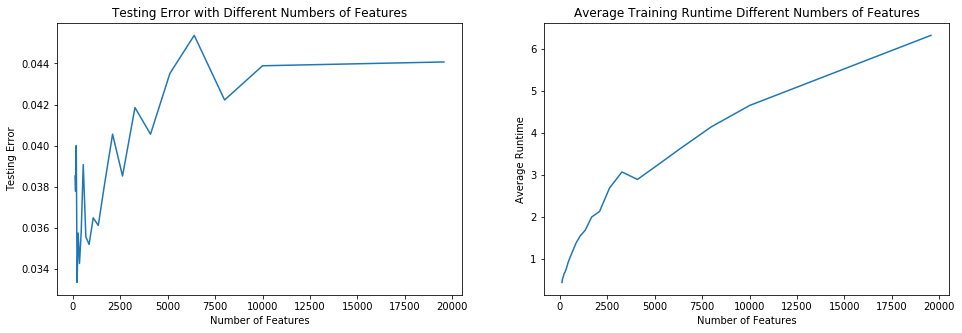

In [0]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.plot(features,errors)
plt.title("Testing Error with Different Numbers of Features")
plt.xlabel("Number of Features")
plt.ylabel("Testing Error")
plt.subplot(1,2,2)
plt.plot(features,times)
plt.title("Average Training Runtime Different Numbers of Features")
plt.xlabel("Number of Features")
plt.ylabel("Average Runtime")
plt.show()

Given this graph, reducing features seems to generally slightly decrease the testing error. This seems extremely wierd as in part 1, it increased the testing error. Perhaps the features that are being removed are the features that are affiliated with having a tumor versus not and thus provide misinformation in actually classifying the tumor. The runtime graph is as expected where the runtime decreases as features are removed.

### d. Using Keras, build a deep learning classifier that performs the same classification task, and determine the learning curve (relationship of number of training samples to prediction accuracy) for your network.


\

In [0]:
#A cnn classification model given an input layer and # of classifications

def classification_model_cnn(i,c):
  model = models.Sequential()
  model.add(layers.Conv1D(filters=16, kernel_size=4, strides=1, padding='valid', input_shape=(i,1)))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling1D(pool_size=1))
  model.add(layers.Conv1D(filters=16, kernel_size=1, strides=1, padding='valid'))
  model.add(layers.Activation('relu'))
  model.add(layers.MaxPooling1D(pool_size=10))
  model.add(layers.Flatten())
  model.add(layers.Dense(200))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(20))
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(c))
  model.add(layers.Activation('softmax'))
  model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(), metrics=['accuracy'])
  return model

#A fully connected classification model given an input layer and # of classifications

def classification_model_fc(i,c):
  model = models.Sequential()
  model.add(layers.InputLayer(i,))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(c, activation='softmax'))
  model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=['accuracy'])
  return model

In [0]:
def five_fold_nn_samples_categorical(model, X, y, eps, samples = 1000):
  train_errors = []
  valid_errors = []
  test_errors = []
  ns = 5
  if samples < 10:
    ns = 2
  kf = KFold(n_splits=ns)
  y_cat = utils.to_categorical(y)
  X_test = X[-1000:]
  Y_test = y[-1000:]
  model.save_weights('empty')
  for train_index, test_index in kf.split(X[:samples]):
      X_train, X_val = X.values[train_index], X.values[test_index]
      y_train, y_val = y_cat[train_index], y_cat[test_index]
      hist = model.fit(x=X_train, y=y_train, epochs=eps, batch_size=25, shuffle=True, validation_data=(np.array(X_val), y_val))
      test_errors.append(np.mean(model.predict(X_test)!= utils.to_categorical(Y_test)))
      model.load_weights('empty')
  return np.mean(test_errors)

In [0]:
set_sizes = [3,7,15,30,60,125,250,500,1000, 2500, 4000]
testing_errors = []
for s in set_sizes:
  testing_errors.append(five_fold_nn_samples_categorical(classification_model_fc(len(type_coding.columns),19), type_coding, type_labels, 10, samples=s))

Train on 1 samples, validate on 2 samples
Epoch 1/10
1/1 [==============================] - 1s 574ms/sample - loss: 2.2392 - acc: 0.0000e+00 - val_loss: 4.4832 - val_acc: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 17ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.4832 - val_acc: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 16ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.4832 - val_acc: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 17ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.4832 - val_acc: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 18ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.4832 - val_acc: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 16ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.4832 - val_acc: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 17ms/sample - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 4.4832 - val_acc: 0.5000
Epoch 8/10
1

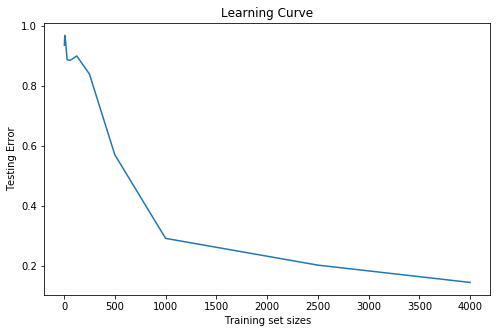

In [0]:
plt.figure(figsize=(8, 5))
plt.plot(set_sizes,testing_errors)
plt.title("Learning Curve")
plt.xlabel("Training set sizes")
plt.ylabel("Testing Error")
plt.show()

Here, removing samples strictly increases the training error. This is extremely similar to what we say before. It also makes sense as we definitely need more samples in order to train the neural network. The change error is is greater if the % change in datasets is greater. Overall, this is definitely the behavior that I would expect.

## Part 3. Cancer Gene Expression Autoencoder (40 points)

#### Loading the Data and Preprocessing

In [0]:
rnaseq = pd.read_csv(
    "/content/drive/My Drive/MLiM-Datasets/HW2/combined_rnaseq_data_lincs1000_combat.tsv",
    keep_default_na=False,
    delimiter='\t',
    na_values=[])

In [0]:
_ = rnaseq.pop("Sample")

In [0]:
def normalize_large_data(df):
  scaler = preprocessing.StandardScaler()
  columns = df.columns
  scaled_df = scaler.fit_transform(df)
  return pd.DataFrame(scaled_df, columns=columns)

rnaseq = normalize_large_data(rnaseq)

### a. Using Keras, build an autoencoder that takes the gene expression values as input, encodes to 50 dimensions and then decodes back to the original width of the input.

In [0]:
# A model for building an autoencoder with parameters input size and number of classes.
def autoencoder_model(i, b):
  model = models.Sequential()
  model.add(layers.InputLayer(i,))
  model.add(layers.Dense(512, activation='tanh'))
  model.add(layers.Dense(256, activation='tanh'))
  model.add(layers.Dense(128, activation='tanh'))
  model.add(layers.Dense(b, activation='tanh'))
  model.add(layers.Dense(128, activation='tanh'))
  model.add(layers.Dense(256, activation='tanh'))
  model.add(layers.Dense(512, activation='tanh'))
  model.add(layers.Dense(i, activation='linear'))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [0]:
# Defines a function to run a bottleneck test. It uses 5-fold and uses mean squared error to determine loss
def test_bottleneck(X, autoencoder):
  losses = []
  X_test = X[int(rnaseq.shape[0]*0.8):]
  kf = KFold(n_splits=5)
  autoencoder.save_weights('empty')
  for train_index, test_index in kf.split(X[:int(rnaseq.shape[0]*0.8)]):
    X_train, X_val = X.values[train_index], X.values[test_index]
    hist = autoencoder.fit(X_train, X_train,
                  epochs=40,
                  batch_size=128,
                  shuffle=True,
                  validation_data=(X_val, X_val))
    losses.append(autoencoder.evaluate(X_test,X_test))
    #Resets the model.
    autoencoder.load_weights('empty')
  return np.mean(losses)

In [0]:
loss = test_bottleneck(rnaseq, autoencoder_model(len(rnaseq.columns), 50))
print()
print("The testing error for a bottlneck of 50 is:", loss)

Train on 9726 samples, validate on 2432 samples
Epoch 1/40
9726/9726 [==============================] - 1s 146us/sample - loss: 0.4710 - val_loss: 0.7140
Epoch 2/40
9726/9726 [==============================] - 1s 62us/sample - loss: 0.3153 - val_loss: 0.6804
Epoch 3/40
9726/9726 [==============================] - 1s 64us/sample - loss: 0.2876 - val_loss: 0.6681
Epoch 4/40
9726/9726 [==============================] - 1s 65us/sample - loss: 0.2678 - val_loss: 0.6555
Epoch 5/40
9726/9726 [==============================] - 1s 64us/sample - loss: 0.2545 - val_loss: 0.6450
Epoch 6/40
9726/9726 [==============================] - 1s 65us/sample - loss: 0.2446 - val_loss: 0.6302
Epoch 7/40
9726/9726 [==============================] - 1s 65us/sample - loss: 0.2379 - val_loss: 0.6168
Epoch 8/40
9726/9726 [==============================] - 1s 63us/sample - loss: 0.2290 - val_loss: 0.6075
Epoch 9/40
9726/9726 [==============================] - 1s 65us/sample - loss: 0.2230 - val_loss: 0.5971
Epoch 

### b. Experiment with changing the width of the bottleneck layer (10, 20, 30, 40, 60, 80) explain what is happening to the loss value when you change the width.

In [0]:
bs = [10, 20, 30, 40, 60, 80]
testing_error = []
for b in bs:
  testing_error.append(test_bottleneck(rnaseq, autoencoder_model(len(rnaseq.columns), b)))
  

Train on 9726 samples, validate on 2432 samples
Epoch 1/40
9726/9726 [==============================] - 1s 154us/sample - loss: 0.5602 - val_loss: 0.7880
Epoch 2/40
9726/9726 [==============================] - 1s 65us/sample - loss: 0.4298 - val_loss: 0.7646
Epoch 3/40
9726/9726 [==============================] - 1s 65us/sample - loss: 0.3972 - val_loss: 0.7513
Epoch 4/40
9726/9726 [==============================] - 1s 65us/sample - loss: 0.3753 - val_loss: 0.7537
Epoch 5/40
9726/9726 [==============================] - 1s 66us/sample - loss: 0.3506 - val_loss: 0.7401
Epoch 6/40
9726/9726 [==============================] - 1s 65us/sample - loss: 0.3275 - val_loss: 0.7341
Epoch 7/40
9726/9726 [==============================] - 1s 65us/sample - loss: 0.3132 - val_loss: 0.7469
Epoch 8/40
9726/9726 [==============================] - 1s 64us/sample - loss: 0.3016 - val_loss: 0.7363
Epoch 9/40
9726/9726 [==============================] - 1s 65us/sample - loss: 0.2929 - val_loss: 0.7328
Epoch 

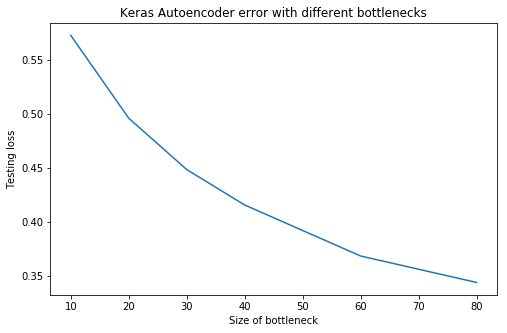

In [0]:
plt.figure(figsize=(8, 5))
plt.plot(bs,testing_error)
plt.title("Keras Autoencoder error with different bottlenecks")
plt.xlabel("Size of bottleneck")
plt.ylabel("Testing loss")
plt.show()

The testing loss increases as the size of the bottleneck shrinks. This behavior makes sense given that the smaller the bottleneck, the less values the model compresses the data into. Evidently, if you are compressing data into a layer of size 10, there is no way that you can contain as much information as if you compress the data into a layer of size 50. Thus, the smaller the bottleneck, the larger the loss.

### c. Experiment with changing the number of layers in the encoder and decoder. What happens if the depth is too small (i.e. 1 ?) what happens when the depth is too large (~20)?

I am going to vary the number of layers between 1 and 19 in intervals of 3. I add layers in different sizes between the bottle neck and input size. I try to add mores than I believe would be more effective in size. FOrinstance, the first one I add is 256. I make sure to sort the layer sizes before I add them to the model.

In [0]:
def auto_encoding_model_layers(i,b,ls = 2): 
  ds = sorted([256, 128, 512, 640, 64, 384, 196, 320, 448, 96, 576, 706, 80, 160, 112, 228, 288, 72][:ls-1])
  model = models.Sequential()
  model.add(layers.InputLayer(i,))
  for d in reversed(ds):
    model.add(layers.Dense(d, activation='tanh'))
  model.add(layers.Dense(b, activation='tanh'))
  for d in ds:
    model.add(layers.Dense(d, activation='tanh'))
  model.add(layers.Dense(i, activation='linear'))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [0]:
testing_errors = []
ls = list(range(1,19,3))
for l in ls:
  testing_errors.append(test_bottleneck(rnaseq, auto_encoding_model_layers(len(rnaseq.columns), 50, ls=l)))

Train on 9726 samples, validate on 2432 samples
Epoch 1/40
9726/9726 [==============================] - 2s 189us/sample - loss: 0.6348 - val_loss: 0.7688
Epoch 2/40
9726/9726 [==============================] - 0s 42us/sample - loss: 0.4095 - val_loss: 0.7013
Epoch 3/40
9726/9726 [==============================] - 0s 41us/sample - loss: 0.3393 - val_loss: 0.6717
Epoch 4/40
9726/9726 [==============================] - 0s 40us/sample - loss: 0.3058 - val_loss: 0.6501
Epoch 5/40
9726/9726 [==============================] - 0s 44us/sample - loss: 0.2849 - val_loss: 0.6351
Epoch 6/40
9726/9726 [==============================] - 0s 41us/sample - loss: 0.2702 - val_loss: 0.6223
Epoch 7/40
9726/9726 [==============================] - 0s 42us/sample - loss: 0.2590 - val_loss: 0.6130
Epoch 8/40
9726/9726 [==============================] - 0s 42us/sample - loss: 0.2514 - val_loss: 0.6035
Epoch 9/40
9726/9726 [==============================] - 0s 42us/sample - loss: 0.2436 - val_loss: 0.5963
Epoch 

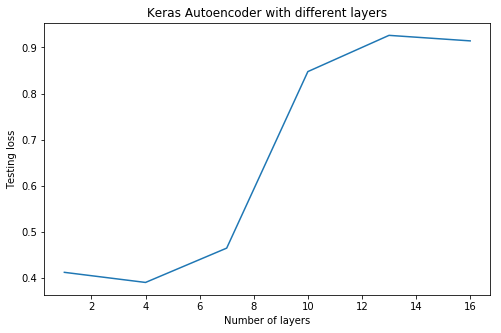

In [0]:
plt.figure(figsize=(8, 5))
plt.plot(list(range(1,19,3)),testing_errors)
plt.title("Keras Autoencoder with Different Depths")
plt.xlabel("Depth")
plt.ylabel("Testing loss")
plt.show()

Interestingly, it appears that the loss at different depths has a minimum at d = 4. This is likely because it is a good median point for where the model isn't too complex for data, but has enough layers to properly funnel the data. If there are less than 4 layers, more data is probably lost as the feature reduction takes too long. If there are more than 4 layers, 40 epochs is probably not enough to fully train all of the layers. At higher numbers of layers like d > 8, the error spikes upward. This is likely because the model is just way too deep to train at all without an extremely large amount of epochs.

### d. What are a two uses of an autoencoder for gene expression data?

One use of autoencoders in gene expression data is to reduce noise in the data. Through autoencoding, we can get rid of any abnormalities in the data. This is extremely useful as a model may percieve these abnormalities to be predictive of the classification.

Another use is to reduce dimensions through encoding. There are a lot of dimensions in gene expression data, so reducing dimensions in an efficient way is extremely valuable as autoencoding perserves only the more meaningful data when it reduces dimensions.

## Writeup

In part 1 of this homework, I learned a lot about machine learning classification with 2 classes. In part (a), I showed that sometimes more data is not better. Using some reason because you decide upon your final dataset can be useful. In this case, one may expect all of the genes to be a better dataset. However, if you think about, a dataset that only includes the protein encoding genes is more relevant. In part (b), I looked at different classical machine learning algorithms. I used LinearSVC, SVC, AdaBoost, KNeighbors, DecisionTree and RandomForest. I was not surprised to see LinearSVC perform the best, but it was interesting to see how quick RandomForest is while maintaining a high degree of accuracy. Also, it was noteworthy that KNeighbors had the least false positives. In part (c), I looked at the effect of feature reduction. It was interesting to see how many features could be removed and only have less than a 0.5% effect on accuracy while running in 1/8 the time. Finally in part (d), I looked at the effect of training with less samples. Similar to part (c), the testing error didn’t increase dramatically until we only used around 400 samples. Thus, this proves that removing samples also works as a technique to reduce runtime if there are a significant number of samples and the runtime is too long. 

In part 2 of the homework, I do the same thing, but with many classes. In (a), we get the same results as I did in part 1. This is not surprising, given the results in part 1a. In (b), I used AdaBoost, KNeighbors, DecisionTree and RandomForest. It was interesting to see how the results were similar except for AdaBoost, which performed worse. RandomForest performed the best, which wasn’t surprising as it did in part 1. Overall, it was cool to see the difference in the results between functions in part 1 and part 2. In (c), the testing error actually seemed to generally decrease as the number of features decreased. This is surprising as I expected the opposite as in part 1. One potential hypothesis I have for why this is the case is that a lot of features are only affiliated with having a tumor versus not having a tumor. Thus, they may provide misinformation in actually classifying the tumor. The decrease is very little, so the other option is just that the RandomTree model doesn’t use a lot of these features and thus the effect of removing features is minimal. In (d), the learning curve shows the effect of using less datasets. As in (d) of part 1, the testing error increases with less datasets. However, the training error increases at a faster pace than it does in part 1. This makes sense as there is more classifications and thus, it takes more data to train the model. The most significant difference to me between the many classifications than the 2 classifications is the runtime. All models took significantly longer in part 2. This shows the difficulty of using so many classifications. It appears that it is exponentially harder to train with more classifications.  

In part 3, I looked at the effect of an autoencoder. In (b), I looked at the effect of changing the bottleneck size. The effect was as expected where the smaller the bottleneck, the greater the loss. However, I was surprised that the loss was still so low even when the bottleneck was so small. In part (c), I look at the effect of the depth of the bottleneck. It was interesting to see that the both a small depth and a high depth don’t perform well. The best was actually a median depth where it was still able to condense the data at a good rate, but wasn’t too large to train. Overall, it is clear that autoencoding is a great way to reduce the noise in data and even condense data if desired. 

Exploring the gene expression datasets was extremely insightful. It was cool to see how predictive the gene data could be and how easy it was to train a model that could determine whether the person has a tumor or not and what kind of tumor they have if they do. This is something that is broadly applicable. One thing that was so surprising was that there were so many ways to do this. A variety of different models were able to reasonably predict the tumor status, which truly shows the power of machine learning. If tumor status is something that is so easy to determine, the medical possibilities of more complex machine learning must be endless.
